In [31]:
#importing the reqquired libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE, SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error


In [32]:
#load the dataset
df = pd.read_csv('/Users/cmoradajr/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
#checking the datasets info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [34]:
#Drop customerID column
df = df.drop('customerID', axis=1)


In [36]:
#one hot encode the churn column
y = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)
X = df.drop(columns=["Churn"])

In [37]:
#Converting the total charges column to numeric
X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:\n" + "\n".join(pd.Series(numeric_cols).astype(str).tolist()))
print("\nCategorical columns:\n" + "\n".join(pd.Series(categorical_cols).astype(str).tolist()))
print()


Numeric columns:
SeniorCitizen
tenure
MonthlyCharges
TotalCharges

Categorical columns:
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod



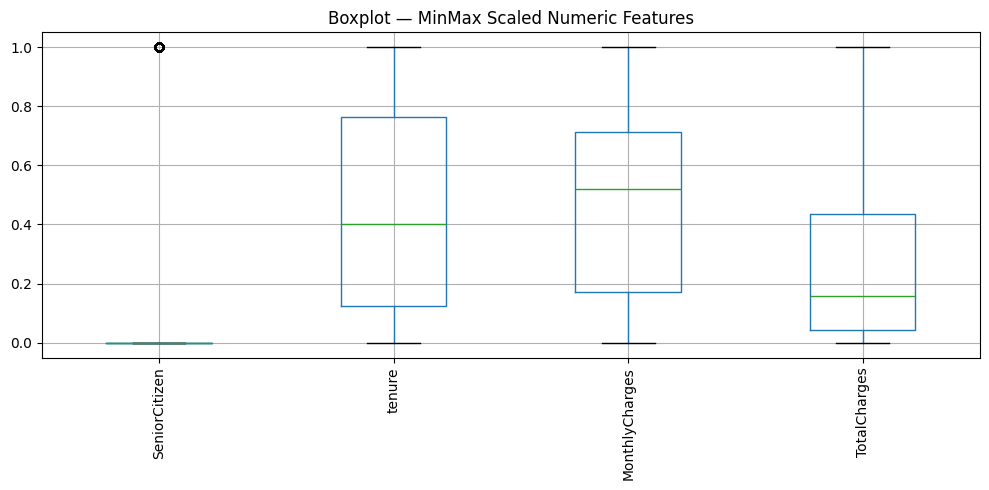

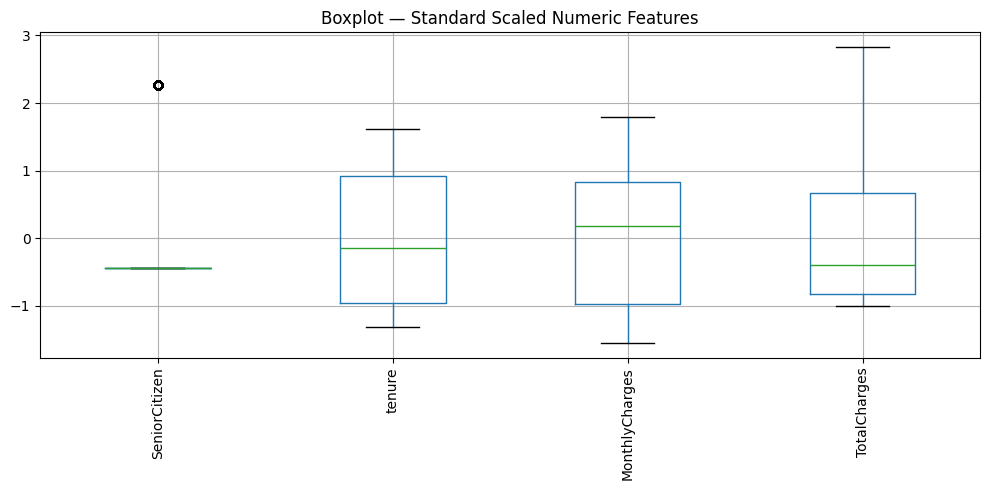

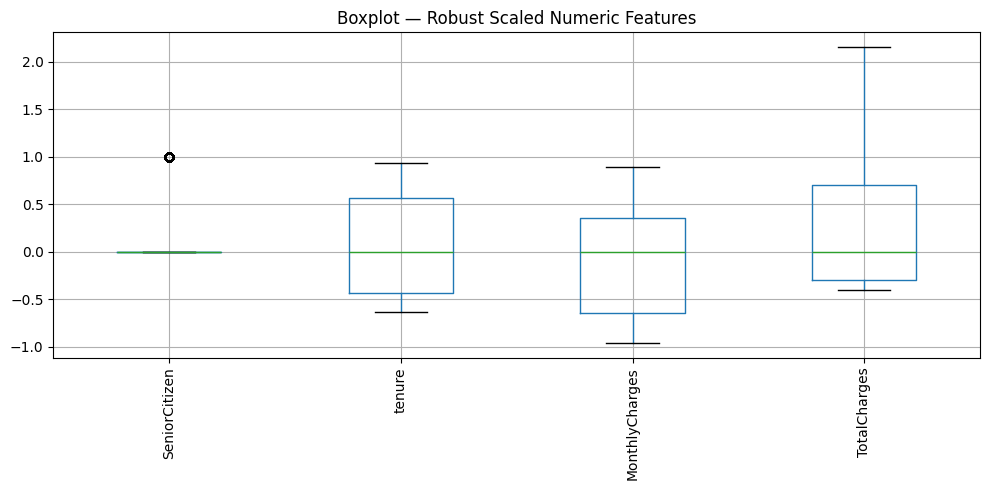

Scaler comparison:
- RobustScaler typically handles outliers best (median/IQR).
- StandardScaler centers values around 0 (mean≈0, std≈1).
- MinMaxScaler maps to [0,1] but is sensitive to outliers.



In [39]:
#inpute numerics, scalers, boxplots
num_imputer = SimpleImputer(strategy="median")
X_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(X[numeric_cols]),
    columns=numeric_cols,
    index=X.index
)

X_num_minmax   = pd.DataFrame(MinMaxScaler().fit_transform(X_num_imputed),   columns=numeric_cols, index=X.index)
X_num_standard = pd.DataFrame(StandardScaler().fit_transform(X_num_imputed), columns=numeric_cols, index=X.index)
X_num_robust   = pd.DataFrame(RobustScaler().fit_transform(X_num_imputed),   columns=numeric_cols, index=X.index)

plt.figure(figsize=(10, 5))
X_num_minmax.boxplot(rot=90)
plt.title("Boxplot — MinMax Scaled Numeric Features")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
X_num_standard.boxplot(rot=90)
plt.title("Boxplot — Standard Scaled Numeric Features")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
X_num_robust.boxplot(rot=90)
plt.title("Boxplot — Robust Scaled Numeric Features")
plt.tight_layout()
plt.show()

print("Scaler comparison:")
print("- RobustScaler typically handles outliers best (median/IQR).")
print("- StandardScaler centers values around 0 (mean≈0, std≈1).")
print("- MinMaxScaler maps to [0,1] but is sensitive to outliers.\n")


In [42]:
# minmax and OHE matrix

numeric_transformer_minmax = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])
categorical_transformer_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

ct_minmax = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_minmax, numeric_cols),
        ("cat", categorical_transformer_ohe, categorical_cols)
    ]
)

X_minmax_all = ct_minmax.fit_transform(X)
feature_names_minmax = ct_minmax.get_feature_names_out()



In [43]:
#variance thresholding
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X_minmax_all)

keep_mask = vt.get_support()
removed_mask = np.logical_not(keep_mask)
removed_features = np.array(feature_names_minmax)[removed_mask]

print("VarianceThreshold(threshold=0.01)")
print("Total features before:", feature_names_minmax.shape[0])
print("Total features after :", X_vt.shape[1])
print("Removed features     :", int(np.sum(removed_mask)))
print("List of removed features:")
print("\n".join(pd.Series(removed_features).astype(str).tolist()))
print()


VarianceThreshold(threshold=0.01)
Total features before: 45
Total features after : 45
Removed features     : 0
List of removed features:




In [44]:
#selectbest chi2
skb = SelectKBest(score_func=chi2, k=10)
skb.fit(X_minmax_all, y)
skb_features = np.array(feature_names_minmax)[skb.get_support()]

print("SelectKBest(chi2, k=10) — Top Features")
print("\n".join(pd.Series(skb_features).astype(str).tolist()))
print()

SelectKBest(chi2, k=10) — Top Features
cat__InternetService_Fiber optic
cat__OnlineSecurity_No
cat__DeviceProtection_No internet service
cat__TechSupport_No
cat__TechSupport_No internet service
cat__StreamingTV_No internet service
cat__StreamingMovies_No internet service
cat__Contract_Month-to-month
cat__Contract_Two year
cat__PaymentMethod_Electronic check



In [45]:
#logisting regression, k10

logreg_for_rfe = LogisticRegression(max_iter=1000, solver="liblinear")
rfe = RFE(estimator=logreg_for_rfe, n_features_to_select=10, step=1)
rfe.fit(X_minmax_all, y)
rfe_features = np.array(feature_names_minmax)[rfe.support_]

print("RFE(LogisticRegression, top=10) — Selected Features")
print("\n".join(pd.Series(rfe_features).astype(str).tolist()))
print()

# Compare SKB vs RFE (set ops, no loops)
skb_set = set(pd.Series(skb_features).tolist())
rfe_set = set(pd.Series(rfe_features).tolist())
overlap = sorted(list(skb_set.intersection(rfe_set)))
only_skb = sorted(list(skb_set.difference(rfe_set)))
only_rfe = sorted(list(rfe_set.difference(skb_set)))

print("Comparison: SelectKBest vs RFE")
print("Overlap:\n" + "\n".join(pd.Series(overlap).astype(str).tolist()))
print("\nOnly in SelectKBest:\n" + "\n".join(pd.Series(only_skb).astype(str).tolist()))
print("\nOnly in RFE:\n" + "\n".join(pd.Series(only_rfe).astype(str).tolist()))
print("\nchi2 = univariate signal; RFE(LogReg) = multivariate model-based importance.\n")

RFE(LogisticRegression, top=10) — Selected Features
num__tenure
num__TotalCharges
cat__MultipleLines_No
cat__InternetService_DSL
cat__OnlineSecurity_No
cat__TechSupport_No internet service
cat__StreamingTV_No internet service
cat__Contract_Month-to-month
cat__Contract_Two year
cat__PaymentMethod_Electronic check

Comparison: SelectKBest vs RFE
Overlap:
cat__Contract_Month-to-month
cat__Contract_Two year
cat__OnlineSecurity_No
cat__PaymentMethod_Electronic check
cat__StreamingTV_No internet service
cat__TechSupport_No internet service

Only in SelectKBest:
cat__DeviceProtection_No internet service
cat__InternetService_Fiber optic
cat__StreamingMovies_No internet service
cat__TechSupport_No

Only in RFE:
cat__InternetService_DSL
cat__MultipleLines_No
num__TotalCharges
num__tenure

chi2 = univariate signal; RFE(LogReg) = multivariate model-based importance.



LASSO with StandardScaler
Chosen alpha: 0.000954
Non-zero coefficients: 17
Top 20 (by |coef|):
num__TotalCharges                     -0.097156
num__tenure                           -0.048411
cat__MultipleLines_No                 -0.043619
cat__PaperlessBilling_No              -0.042944
cat__Contract_One year                -0.028850
cat__DeviceProtection_No               0.001967
num__SeniorCitizen                     0.016515
cat__Dependents_No                     0.017824
cat__OnlineBackup_No                   0.019493
num__MonthlyCharges                    0.025357
cat__StreamingTV_Yes                   0.036791
cat__StreamingMovies_Yes               0.039546
cat__TechSupport_No                    0.052510
cat__OnlineSecurity_No                 0.052634
cat__PaymentMethod_Electronic check    0.070830
cat__Contract_Month-to-month           0.074468
cat__InternetService_Fiber optic       0.153951

LASSO shrinks some coefficients exactly to zero; among correlated features it tends to k

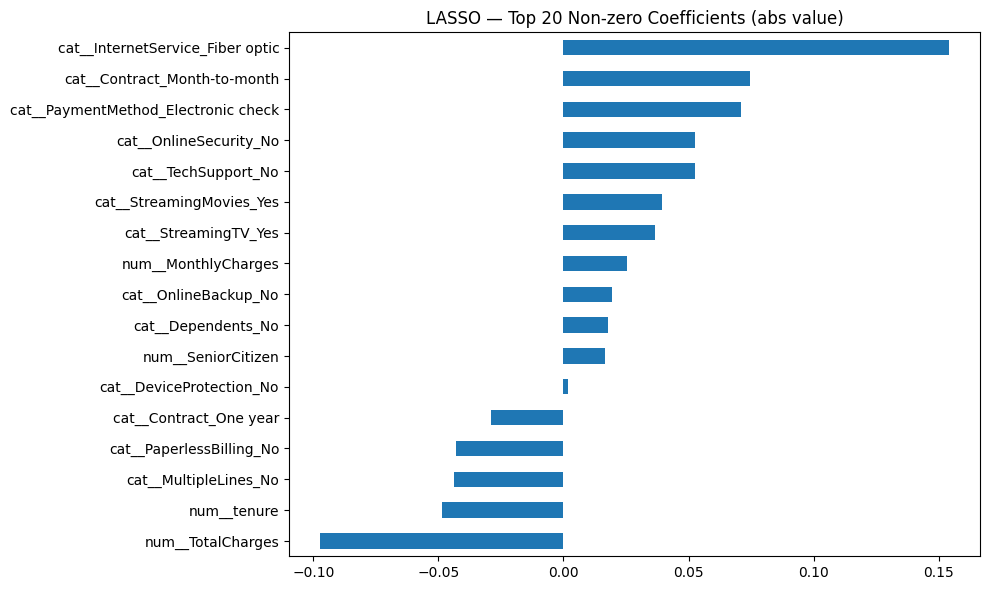

In [46]:
# lasso standard , OHE

numeric_transformer_std = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
ct_std = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_std, numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ]
)
X_std_all = ct_std.fit_transform(X)
feature_names_std = ct_std.get_feature_names_out()

lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X_std_all, y)

coefs = pd.Series(lasso.coef_, index=feature_names_std)
non_zero = coefs[coefs.abs() > 1e-8].sort_values(key=lambda s: s.abs(), ascending=False)
top20 = non_zero.head(20).sort_values()

print("LASSO with StandardScaler")
print("Chosen alpha:", f"{lasso.alpha_:.6f}")
print("Non-zero coefficients:", int(non_zero.shape[0]))
print("Top 20 (by |coef|):")
print(top20.to_string())
print("\nLASSO shrinks some coefficients exactly to zero; among correlated features it tends to keep one and shrink others.\n")

plt.figure(figsize=(10, 6))
top20.plot(kind="barh")
plt.title("LASSO — Top 20 Non-zero Coefficients (abs value)")
plt.tight_layout()
plt.show()

In [50]:
#final pipeline

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols)
    ]
)

selector = SelectFromModel(LassoCV(cv=5, random_state=42, max_iter=5000))
clf = LogisticRegression(max_iter=1000, solver="liblinear")

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("feature_select", selector),
    ("clf", clf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
# RMSE: compute as sqrt(MSE) for compatibility across sklearn versions
rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print("Final Pipeline — Test Metrics")
print("Accuracy:", f"{accuracy:.4f}")
print("ROC-AUC :", f"{roc_auc:.4f}")
print("RMSE    :", f"{rmse:.4f}")
print("MAE     :", f"{mae:.4f}")
print()

# Names of features that survive LASSO inside the pipeline (no loops)
preprocess_fitted = preprocess.fit(X_train)
X_train_processed = preprocess_fitted.transform(X_train)
feat_names_after_preprocess = preprocess_fitted.get_feature_names_out()

selector_for_names = SelectFromModel(LassoCV(cv=5, random_state=42, max_iter=5000)).fit(
    X_train_processed, y_train
)
kept_mask = selector_for_names.get_support()
kept_features = np.array(feat_names_after_preprocess)[kept_mask]

print("Features kept by SelectFromModel(LassoCV) in final pipeline:")
print("\n".join(pd.Series(kept_features).astype(str).tolist()))

Final Pipeline — Test Metrics
Accuracy: 0.8034
ROC-AUC : 0.8431
RMSE    : 0.4434
MAE     : 0.1966

Features kept by SelectFromModel(LassoCV) in final pipeline:
num__SeniorCitizen
num__tenure
num__MonthlyCharges
num__TotalCharges
cat__Dependents_No
cat__MultipleLines_No
cat__MultipleLines_Yes
cat__InternetService_Fiber optic
cat__OnlineSecurity_No
cat__OnlineBackup_No
cat__DeviceProtection_No
cat__TechSupport_No
cat__StreamingTV_Yes
cat__StreamingMovies_Yes
cat__Contract_Month-to-month
cat__Contract_One year
cat__PaperlessBilling_No
cat__PaymentMethod_Credit card (automatic)
cat__PaymentMethod_Electronic check
